# Embedded Syestem Assignment - Power Measurement of a UWB Embedded Platform


## Introduction
In this workbook I will explain a method to measure te power comsumption of an embedded system, in this example we used a Low-power board for Ultra Wide Band (UWB) based on DWM1001 module.

## Environment setup
To measure the power com

# Python execution

TODO:
 - [ ] Theory
 - [ ] Controlling lables
 - [ ] Managing multiple files

## **Before executing the notebook** 
1. Upload the oscilloscope output files under lateral filesystem menù (only if you are using Google Colab)
2. Define under here the number of files you have uploaded or you want to take in consideration during calculus [NOT IMPLEMENTED YET]
> Note: the file names should be in `data-ok_<number of the file>.csv` format
3. Define the value of the $R_{sense}$ used for mesurement in $\Omega$
4. Define also the channel for each function

## Debug configuration
For unknown reasons, with datafiles aquired during the lab session, the results obtained are not coherent with the expected ones. To debug the code, I defined a variable `debug` that if set to `True` will use a known datafile `data1.csv` that contains data acquired with a known configuration (you can modify the file number by changing the variable `fileN`).



In [ ]:
Vcc = 5.0
Vdd = 3.3
filenameTemplate = "data/data-ok_"
fileCount = 1 
Rsense = 1
# debug = False
debug = True
fileN = 1


# Define Channles Usage
if debug == False:
  functions = {
      'Vdd_CH':    'Channel C (V)',
      'Vsense_CH': 'Channel B (V)',
      'GPIO13_CH': 'Channel D (V)',
      'GPIO23_CH': 'Channel A (V)'
  }

else:
  if fileN == 1:
    functions = {
        'Vdd_CH':    'Channel A (V)',
        'Vsense_CH': 'Channel B (V)',
        'GPIO13_CH': 'Channel D (V)',
        'GPIO23_CH': 'Channel C (V)'
    }
  elif fileN == 2:
    functions = {
        'Vdd_CH':    'Channel A (V)',
        'Vsense_CH': 'Channel D (V)',
        'GPIO13_CH': 'Channel B (V)',
        'GPIO23_CH': 'Channel C (V)'
    }

# Find channel for function:
def get_channel(function_name):
    return functions.get(function_name)


## Importing libraries


In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid
import seaborn as sns
from matplotlib import pyplot as plt
import math
import glob
import os

sns.set_style("whitegrid")
# sns.set(rc={'figure.figsize':(11,7)})

## Creating DataFrames


In [3]:
# Read the first two lines (headers)
if debug == False:
  df_all = []
  files = glob.glob(filenameTemplate)
  for file in range(1, fileCount + 1):
    # Leggi le prime due righe (header e unità)
    header = pd.read_csv(f"{filenameTemplate}{file}.csv", nrows=2)
    # Leggi i dati (saltando le prime due righe)
    df = pd.read_csv(f"{filenameTemplate}{file}.csv", skiprows=2)
    
    # Crea intestazioni combinate "Nome [unità]"
    new_cols = [f"{col} {unit}" for col, unit in zip(header.columns, header.iloc[0])]
    df.columns = new_cols
    
    # (facoltativo) aggiungi il nome file per tracciabilità
    df["source"] = f"{filenameTemplate}{file}.csv"
    
    # Aggiungi alla lista
    df_all.append(df)
    
  print(f"Number of files read: {len(df_all)}")
  # Concatenate all dataframes
  df = pd.concat(df_all, ignore_index=True)
    
else:
  # Read the first two lines (headers)
  header = pd.read_csv(f"data/data{fileN}.csv", nrows=2)
  # Read the dataset
  df = pd.read_csv(f"data/data{fileN}.csv", skiprows=2)
  # Create new cols name by inserting de um into the name
  new_columns = [
      f"{col} {unit}" for col, unit in zip(header.columns, header.iloc[0])
  ]
  # Renaming dataset column names
  df.columns = new_columns

# Remove unused columns
if( debug ):
  df = df[['Time (s)', 'Channel A (V)', 'Channel B (V)', 'Channel C (V)', 'Channel D (V)']]
  df.info()
else:
  df = df[['Time (s)', 'Channel A (V)', 'Channel B (V)', 'Channel C (V)', 'Channel D (V)', 'source']]
  df.info()
  
# Drop NaN
df = df[['Time (s)', 'Channel A (V)', 'Channel B (V)', 'Channel C (V)', 'Channel D (V)']].apply(pd.to_numeric, errors='coerce')
df = df.dropna()

# df.info()

print(df.shape)
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Time (s)       100003 non-null  float64
 1   Channel A (V)  100003 non-null  object 
 2   Channel B (V)  100003 non-null  float64
 3   Channel C (V)  100003 non-null  float64
 4   Channel D (V)  100003 non-null  object 
dtypes: float64(3), object(2)
memory usage: 3.8+ MB
(99997, 5)
   Time (s)  Channel A (V)  Channel B (V)  Channel C (V)  Channel D (V)
0   -0.5999       4.934024       -0.03937       0.000000       4.894962
1   -0.5998       4.934024       -0.03937       0.000000       4.934332
2   -0.5997       4.894654        0.00000       0.039524       4.894962
3   -0.5996       4.894654        0.00000       0.039524       4.894962
4   -0.5995       4.934024        0.00000       0.000000       4.934332


## Data Analisys

### Row plot

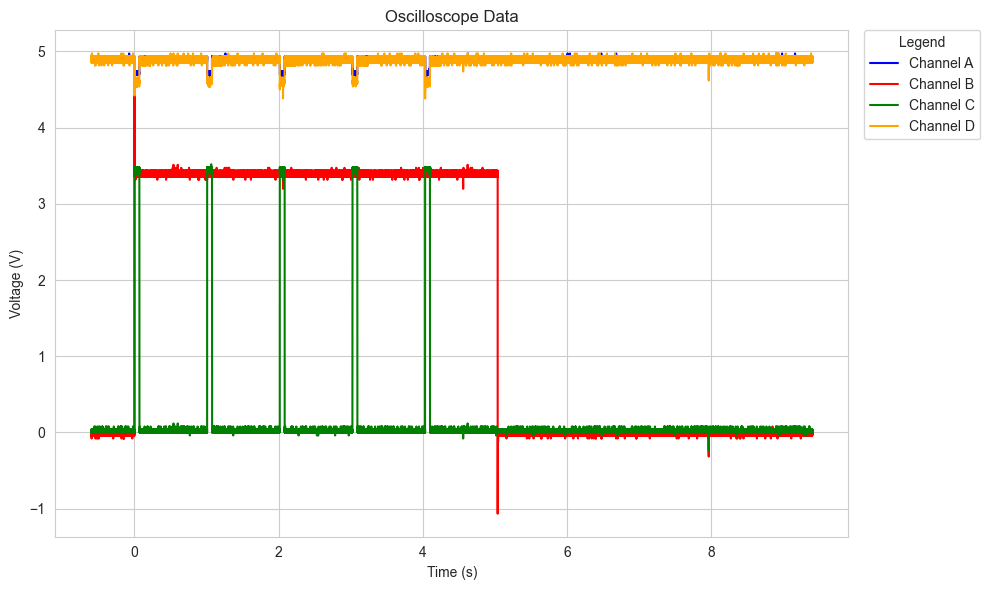

In [4]:
# Creating Axex and figure
fig, ax = plt.subplots(figsize=(10, 6))

# Row plot
sns.lineplot(data=df, x='Time (s)', y='Channel A (V)', ax= ax, label = "Channel A", color = 'blue')
sns.lineplot(data=df, x='Time (s)', y='Channel B (V)', ax= ax, label = "Channel B", color = 'red')
sns.lineplot(data=df, x='Time (s)', y='Channel C (V)', ax= ax, label = "Channel C", color = 'green')
sns.lineplot(data=df, x='Time (s)', y='Channel D (V)', ax= ax, label = "Channel D",color = 'orange')

# Set legend position in on right side (off of the chart)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Legend', bbox_to_anchor=(1.02, 1), loc='upper left',borderaxespad=0.)
ax.set_title('Oscilloscope Data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
plt.tight_layout()

# Plot
plt.show()


### Plot using signal names

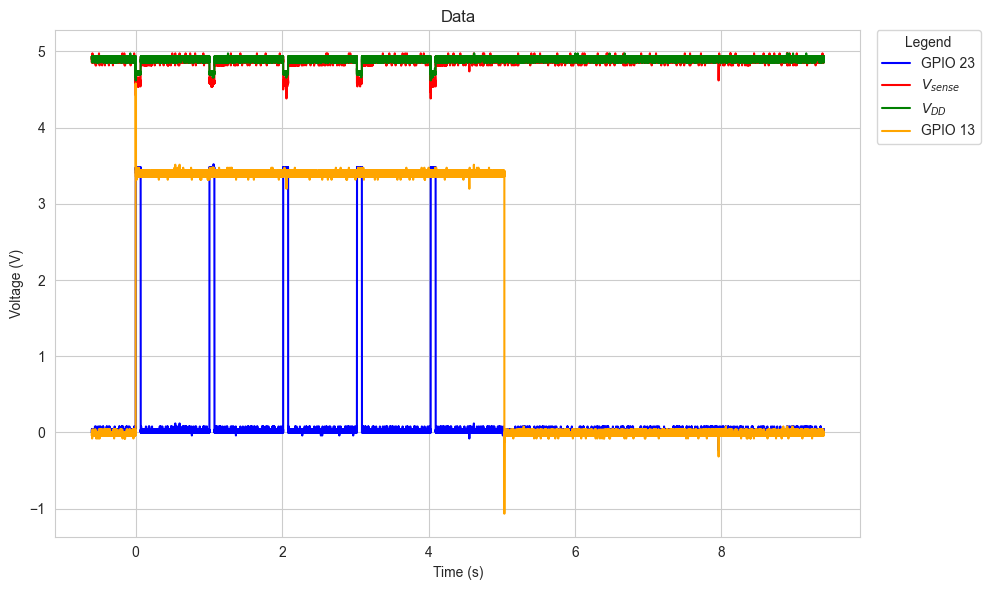

In [5]:
# Creating Axex and figure
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df, x='Time (s)', y=get_channel('GPIO23_CH'), ax= ax, label = "GPIO 23", color = 'blue')
sns.lineplot(data=df, x='Time (s)', y=get_channel('Vsense_CH'), ax= ax, label = "$V_{sense}$", color = 'red')
sns.lineplot(data=df, x='Time (s)', y=get_channel('Vdd_CH'), ax= ax, label = "$V_{DD}$", color = 'green')
sns.lineplot(data=df, x='Time (s)', y=get_channel('GPIO13_CH'), ax= ax, label = "GPIO 13",color = 'orange')

# Set legend position in on right side (off of the chart)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Legend', bbox_to_anchor=(1.02, 1), loc='upper left',borderaxespad=0.)
ax.set_title('Data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
plt.tight_layout()

# Plot
plt.show()

### Calculating Current, Power and Energy
#### Current derivation
The current flowing through the device under test (DUT) can be calculated using Ohm's law:
$$ V_{shunt}(t) = V_{dd}(t) - V_{sense}(t)$$
$$ I(t) = \frac{V_{shunt}(t)}{R_{sense}} $$

In my case I converted the current in mA, so the formula becomes:
$$ I(t) = \frac{V_{shunt}(t)}{R_{sense}} \cdot 1000 $$

#### Power derivation
The power consumption of the DUT can be calculated as:
$$ P(t) = V_{dd}(t) \cdot I(t) $$

#### Energy derivation
Having the power consumption, the energy consumed by a system can be calculated as the integral of the power over time:
$$ E(t)= \int_{0}^{t} P(t) dt $$
and for a discrete form:
$$ E(n) = \sum_{i=0}^{n} P(i) \cdot \Delta t $$
where:
- $\Delta t$ is the time interval between two consecutive samples;
- $n$ is the sample at $t$ time.

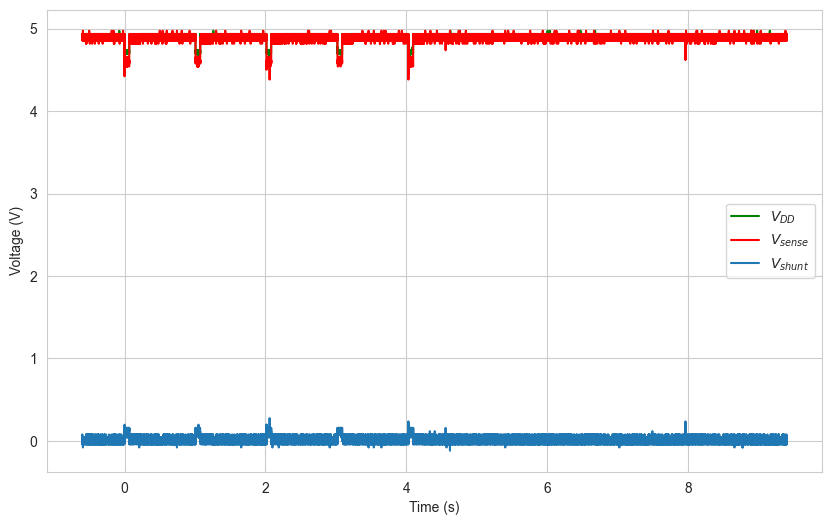

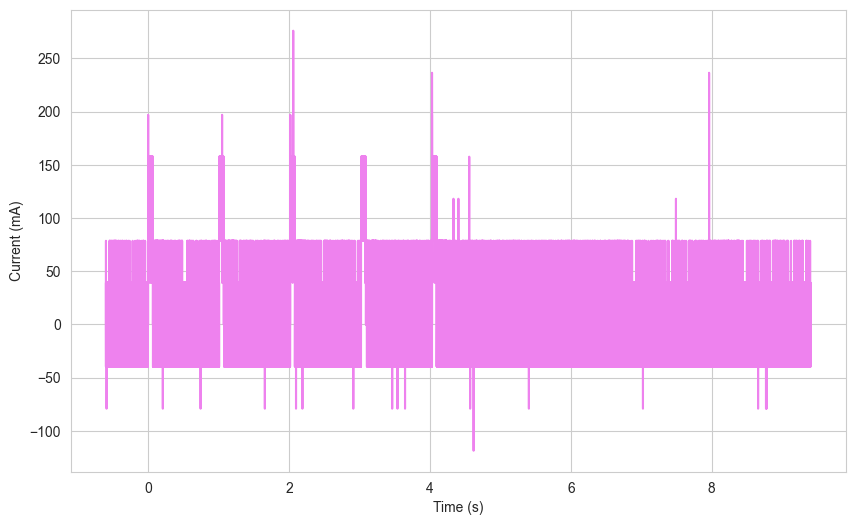

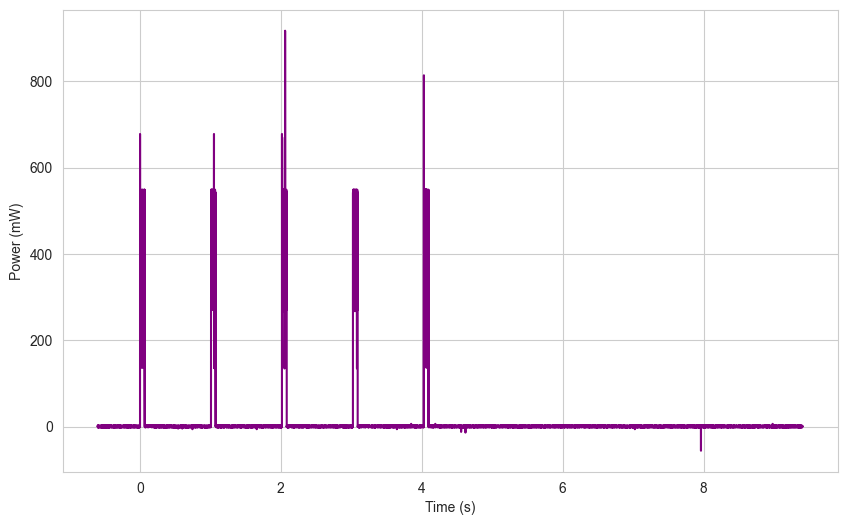

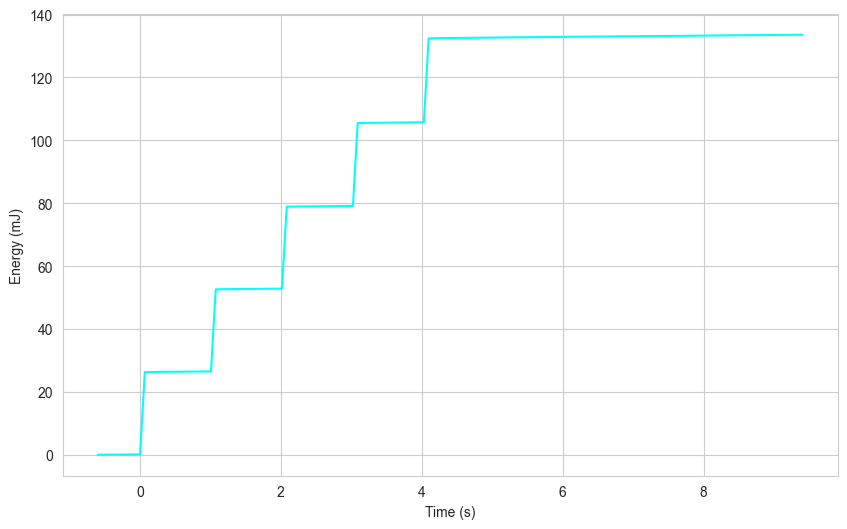

In [6]:
# Calculating the voltage drop over Rsense
df['Shunt Voltage (V)'] = df[get_channel('Vdd_CH')] - df[get_channel('Vsense_CH')]

# Calculating the current drowned by the system
df['Current (mA)'] = ((df['Shunt Voltage (V)']) / Rsense ) * 1000

# Calculating the power consumption of the wole system (shunt included)
df['Power (mW)'] = df['Current (mA)'] * df['Channel C (V)']

# Calculating the energy
df["Energy (mJ)"] = cumulative_trapezoid(df["Power (mW)"], x=df["Time (s)"], initial=0)

# Calculating mean and std of the wole application
powerMean = df['Power (mW)'].mean()
powerStd = df['Power (mW)'].std()

#Plot Voltages over time
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x='Time (s)', y=get_channel('Vdd_CH'), ax= ax, label = "$V_{DD}$", color = 'green')
sns.lineplot(data=df, x='Time (s)', y=get_channel('Vsense_CH'), ax= ax, label = "$V_{sense}$", color = 'red')
sns.lineplot(data=df, x='Time (s)', y='Shunt Voltage (V)', ax= ax, label = "$V_{shunt}$")
ax.set_ylabel("Voltage (V)")
plt.show()

# Plot the current over time
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x='Time (s)', y='Current (mA)', ax=ax, color = 'violet')
plt.show()

# Plot the power over time
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x='Time (s)', y='Power (mW)', ax=ax, color = 'purple')
plt.show()

# Plot energy over time
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x='Time (s)', y='Energy (mJ)', ax=ax, color = 'cyan')
plt.show()


### Subdividing in phases and calculating energy per phase
First of all we need to identify the different phases, and this can be done using the valued of the two GPIOs signals; the corrisponding of each binary code can be found in the table below:
| GPIO13 | GPIO23 | Phase          |
|--------|--------|----------------|
|   0    |   0    | Idle           |
|   1    |   1    | Transmission   |
|   1    |   0    | Reception      |

Knowing that, data can be filtered to identify the different phases and calculate the mean power and energy consumption for each of them.

#### Calculating mean power (and std) per phase
To calculate the mean power consumption per phase, data can be filtered using the GPIOs values as conditions, and then the mean and std functions can be applied to the filtered data.

#### Identifying transition points
For energy the process is a bit more complex, because we need to identify the transition points between the different phases to calculate the energy consumed in each of them.
So for identifying the phases I calculated the derivative over time of the two GPIOs signals, and identifying the transition points using the condition two conditions:
- $\frac{\text{d}(GPIO)}{\text{d}t}\gg 0$ for rising edges;
  

- $\frac{\text{d}(GPIO)}{\text{d}t}\ll 0$ for falling edges.

After identifying the transition points, the energy used in each phase can be calculated by sbtracting the energy value at the start of the phase to the energy value at the end of that phase.
$$ E_{phase} = E(t_{end}) - E(t_{start}) $$

Then for each phase the mean and std of the energy consumption can be easily calculated.

In [ ]:
#Transmit Mean Power (by filtering using GPIOs values)
dfTx = df[(df[get_channel('GPIO13_CH')] > Vdd/2) & (df[get_channel('GPIO23_CH')] > Vdd/2) & (df['Time (s)'] < 6)]
powerTxMean = dfTx['Power (mW)'].mean()
powerTxStd = dfTx['Power (mW)'].std()

#############   DEBUG   #############
# dfTx_filtered = df.copy()
# dfTx_filtered.loc[~((df[get_channel('GPIO13_CH')] > Vdd/2) & (df[get_channel('GPIO23_CH')] > Vdd/2) & (df['Time (s)'])), 
#                   [ 'Channel A (V)', 
#                     'Channel B (V)',
#                     'Channel C (V)',
#                     'Channel D (V)',
#                     'Shunt Voltage (V)',
#                     'Current (mA)',
#                     'Power (mW)',
#                   ]] = 0
# newPowerTxMean = dfTx_filtered['Power (mW)'].mean()
# newPowerTxStd = dfTx_filtered['Power (mW)'].std()
# # print(df.info())
# # print(dfTx_filtered.info())
# #Plot Voltages over time
# fig, ax = plt.subplots(figsize=(10, 6))
# ax2 = ax.twinx()
# sns.lineplot(data=dfTx_filtered, x='Time (s)', y='Energy (mJ)', ax= ax, label = "Energy (mJ)", color = 'cyan')
# sns.lineplot(data=dfTx_filtered, x='Time (s)', y='Power (mW)', ax= ax2, label = "Power (mW)", color = 'purple')
# ax2.set_ylabel('Power (mW)')
# ax2.grid(False)

# plt.show()

# # Plot the current over time
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.lineplot(data=dfTx_filtered, x='Time (s)', y='Current (mA)', ax=ax, color = 'violet')
# plt.show()

# # Plot the power over time
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.lineplot(data=dfTx_filtered, x='Time (s)', y='Power (mW)', ax=ax, color = 'purple')
# plt.show()

# # Plot energy over time
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.lineplot(data=dfTx_filtered, x='Time (s)', y='Energy (mJ)', ax=ax, color = 'cyan')
# plt.show()
############# DEBUG END #############

#Idle Mean Power (by filtering using GPIOs values)
dfIdle = df[(df[get_channel('GPIO13_CH')] < Vdd/2) & (df[get_channel('GPIO23_CH')] < Vdd/2) & (df['Time (s)'] > 1)]
powerIdleMean = dfIdle['Power (mW)'].mean()
powerIdleStd = dfIdle['Power (mW)'].std()

print("\nTransmit Task Power")
print(f"\tMean TX Powe: {powerTxMean} mW")
print(f"\tStd TX Power: {powerTxStd} mW")
print("\nIdle Task Power")
print(f"\tMean Idle Power: {powerIdleMean} mW")
print(f"\tStd Idle Power: {powerIdleStd} mW")
print("\nTotal Task Power")
print(f"\tMean Power: {powerMean} mW")
print(f"\tStd Power: {powerStd} mW")


# Calculate the derivative of GPIO signals
df['GPIO13_Diff'] = df[get_channel('GPIO13_CH')].diff() / df['Time (s)'].diff()
df['GPIO23_Diff'] = df[get_channel('GPIO23_CH')].diff() / df['Time (s)'].diff()

# Find rising and falling edges (when an edge occurs, the derivative is high (positive or negative))
risingEdges_GPIO13 = df[(df['GPIO13_Diff'] > 10000)]
risingEdges_GPIO23 = df[(df['GPIO23_Diff'] > 10000)]
fallingEdges_GPIO13 = df[(df['GPIO13_Diff'] < -10000)]
fallingEdges_GPIO23 = df[(df['GPIO23_Diff'] < -10000)]

# Calculate the integral beetween rising and falling edges for GPIO23 (Transmit Task)
txEnergyArr = []
for i in range(min(len(risingEdges_GPIO13), len(fallingEdges_GPIO13))):
  energy = fallingEdges_GPIO23.iloc[i]['Energy (mJ)'] - risingEdges_GPIO23.iloc[i]['Energy (mJ)']
  txEnergyArr.append(energy)
    
# Calculate mean and std of the tx packets
txEnergyMean = np.mean(txEnergyArr)
txEnergyStd = np.std(txEnergyArr)  

# Calculate the integral beetween the last falling edges of GPIO13 and the end (Idle Task)
if len(fallingEdges_GPIO13) > 0:
  i = len(fallingEdges_GPIO13) - 1
  last = len(df) - 1
  time = fallingEdges_GPIO13.iloc[i]['Time (s)']
  idleEnergy = df.iloc[last]["Energy (mJ)"] - fallingEdges_GPIO13.iloc[i]['Energy (mJ)']

#Calculate the integral beetween rising and falling edges for GPIO13 (Entire Task)
taskEnergyArr = []
min(len(risingEdges_GPIO13), len(fallingEdges_GPIO13))
for i in range(min(len(risingEdges_GPIO13), len(fallingEdges_GPIO13))):
  timeRise = risingEdges_GPIO13.iloc[i]['Time (s)']
  timeFall = fallingEdges_GPIO13.iloc[i]['Time (s)']  
  energyAtRise = risingEdges_GPIO13.iloc[i]['Energy (mJ)']
  energyAtFall = fallingEdges_GPIO13.iloc[i]['Energy (mJ)']
  energy = energyAtFall - energyAtRise
  # print(f"Time at rising edge: {risingEdges_GPIO13.iloc[i]['Time (s)']}, Time at falling edge: {fallingEdges_GPIO13.iloc[i]['Time (s)']}")
  # print(f"Energy at rising edge: {energyAtRise}, Energy at falling edge: {energyAtFall}, Difference: {energy}")
  # print(f"DF Energy at rising edge: {dfEnergyAtRise}, DF Energy at falling edge: {dfEnergyAtFall}")
  taskEnergyArr.append(energy)
    
# Calculate mean and std of the total task
taskEnergyMean = np.mean(taskEnergyArr)
taskEnergyStd = np.std(taskEnergyArr)
  
print("\nTransmit Task Energy")
print(f"\tMean TX Energy: {txEnergyMean} mJ")
print(f"\tStd TX Energy: {txEnergyStd} mJ")

print(f"\nIdle Energy: {idleEnergy} mJ")

print("\nTask Energy")
print(f"\tMean Task Energy: {taskEnergyMean} mJ")
print(f"\tStd Task Energy: {taskEnergyStd} mJ")


Transmit Task Power
	Mean TX Powe: 387.86076271307974 mW
	Std TX Power: 95.74052870206216 mW

Idle Task Power
	Mean Idle Power: 0.20564582267275394 mW
	Std Idle Power: 0.8215599607297994 mW

Total Task Power
	Mean Power: 13.344136463128995 mW
	Std Power: 72.26394986545604 mW

Transmit Task Energy
	Mean TX Energy: 26.178938402436522 mJ
	Std TX Energy: 0.0 mJ

Idle Energy: 0.8974636643550866 mJ

Task Energy
	Mean Task Energy: 132.5971875783909 mJ
	Std Task Energy: 0.0 mJ
